# Airbnb Price Analysis – Paris

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, cohen_kappa_score
)

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from geopy.distance import geodesic

In [14]:
# Load dataset
df = pd.read_csv("../data/clean/airbnb_clean.csv")

In [16]:
# Keep only Paris listings
df = df[df["city"] == "Paris"].copy()

# Compute price per person
df["price_per_person"] = df["price"] / df["accommodates"]

# Remove extreme outliers (max 500 €/person/night)
df = df[df["price_per_person"] < 500]

# Classification – Predicting “Luxury” Listings

#### I define Luxury = 1 if price/person > 150 €, else 0.

In [52]:
# Create binary target
df["luxury"] = (df["price_per_person"] > 150).astype(int)

print("Class distribution (before resampling):")
print(df["luxury"].value_counts(normalize=True))

Class distribution (before resampling):
luxury
0    0.933467
1    0.066533
Name: proportion, dtype: float64


#### Features & Target with Encoded Categories

In [54]:
# Features (numeric + categorical)
features_class = [
    "accommodates", "bedrooms", "beds",
    "availability_365", "number_of_reviews",
    "room_type", "neighbourhood_cleansed"
]

X = df[features_class]
y = df["luxury"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:", y_train.value_counts(normalize=True))

Before SMOTE: luxury
0    0.933461
1    0.066539
Name: proportion, dtype: float64


#### Preprocessing

In [57]:
numeric_features = ["accommodates", "bedrooms", "beds", "availability_365", "number_of_reviews"]
categorical_features = ["room_type", "neighbourhood_cleansed"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#### Handle Class Imbalance (SMOTE)

In [60]:
# Encode + impute first
X_train_imp = preprocessor.fit_transform(X_train)
X_test_imp = preprocessor.transform(X_test)

# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imp, y_train)

print("After SMOTE:", y_train_res.value_counts(normalize=True))

After SMOTE: luxury
0    0.5
1    0.5
Name: proportion, dtype: float64


#### Helper Function for Evaluation

In [63]:
def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{model_name} - Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=2))
    print(f"Cohen’s Kappa Score: {cohen_kappa_score(y_test, y_pred):.2f}")
    if y_prob is not None:
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.2f}")

    # Figures
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title(f"{model_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
        axes[1].plot([0, 1], [0, 1], "k--")
        axes[1].set_title(f"{model_name} ROC Curve")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

#### Train Models


Random Forest - Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      9979
           1       0.27      0.42      0.33       711

    accuracy                           0.89     10690
   macro avg       0.61      0.67      0.63     10690
weighted avg       0.91      0.89      0.90     10690

Cohen’s Kappa Score: 0.27
ROC-AUC Score: 0.80


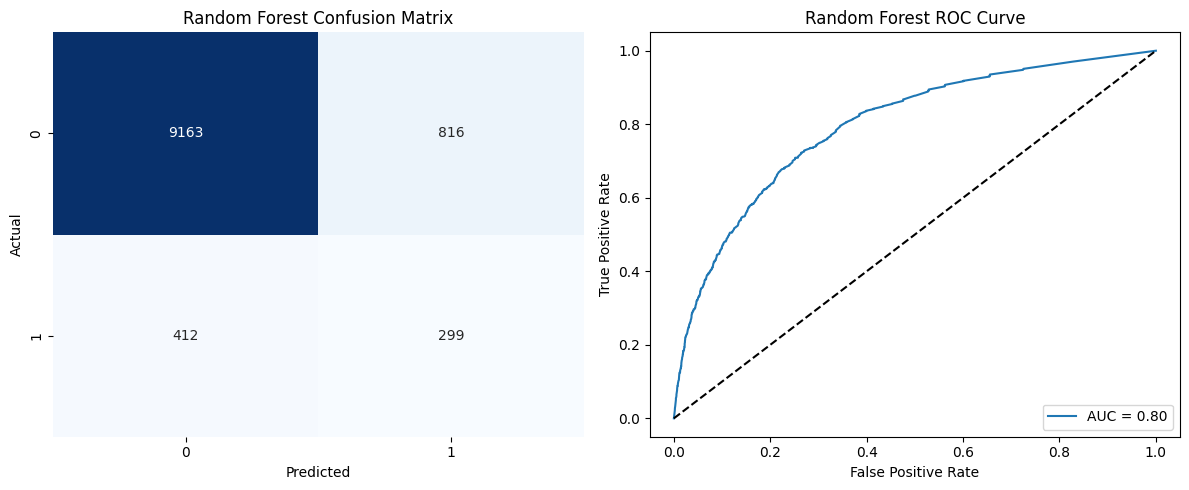

In [25]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train_res, y_train_res)
evaluate_classifier(rf, X_test_imp, y_test, model_name="Random Forest")


XGBoost - Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      9979
           1       0.24      0.57      0.33       711

    accuracy                           0.85     10690
   macro avg       0.60      0.72      0.62     10690
weighted avg       0.92      0.85      0.88     10690

Cohen’s Kappa Score: 0.27
ROC-AUC Score: 0.83


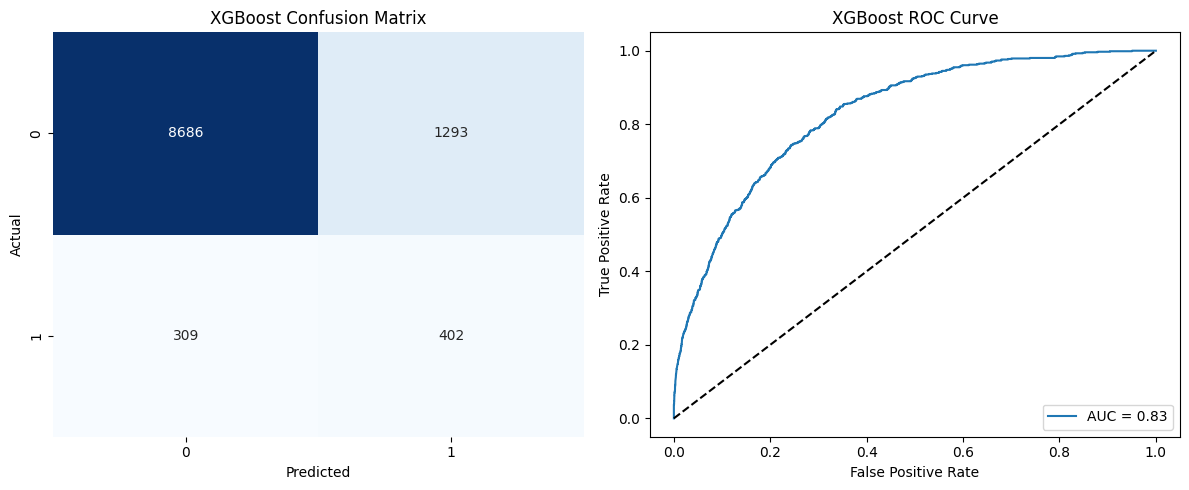

In [44]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, n_jobs=-1, scale_pos_weight=1
)
xgb.fit(X_train_res, y_train_res)
evaluate_classifier(xgb, X_test_imp, y_test, model_name="XGBoost")

# Regression – Predicting Price per Person

#### Features & Target

In [71]:
target = "price_per_person"
y_reg = df[target]

features_reg = [
    "latitude", "longitude", "accommodates", "bedrooms", "beds",
    "availability_365", "number_of_reviews",
    "room_type", "neighbourhood_cleansed"
]
X_reg = df[features_reg]

X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

#### Train 4 Models

In [73]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6,
                            subsample=0.8, colsample_bytree=0.8,
                            random_state=42, n_jobs=-1)
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "RMSE": rmse, "R²": r2})
    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.3f}")

results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\nSummary of models performance:")
print(results_df)

Linear Regression → RMSE: 49.70, R²: 0.161
Random Forest → RMSE: 49.63, R²: 0.164
Gradient Boosting → RMSE: 46.78, R²: 0.257
XGBoost → RMSE: 45.69, R²: 0.291

Summary of models performance:
               Model       RMSE        R²
3            XGBoost  45.687182  0.291244
2  Gradient Boosting  46.776011  0.257059
1      Random Forest  49.632509  0.163549
0  Linear Regression  49.700239  0.161265



Best model: XGBoost


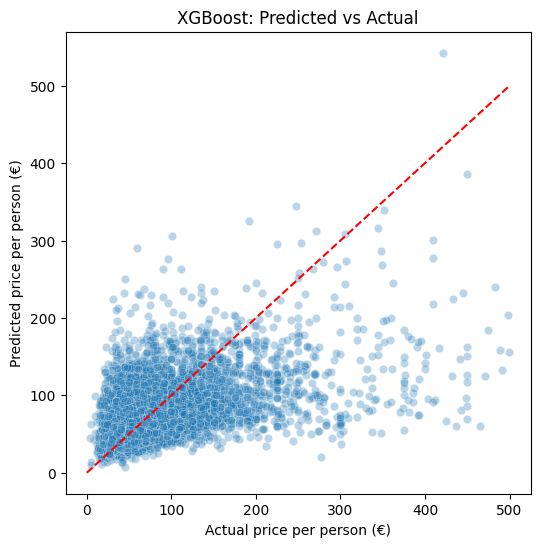

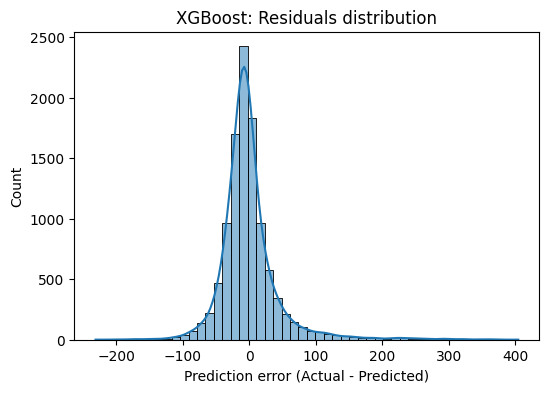

In [75]:
best_model_name = results_df.iloc[0]["Model"]
print("\nBest model:", best_model_name)

best_model = models[best_model_name]
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("model", best_model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Scatter plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([0, 500], [0, 500], "r--")
plt.xlabel("Actual price per person (€)")
plt.ylabel("Predicted price per person (€)")
plt.title(f"{best_model_name}: Predicted vs Actual")
plt.show()

# Residuals distribution
plt.figure(figsize=(6,4))
sns.histplot(y_test - y_pred, bins=50, kde=True)
plt.xlabel("Prediction error (Actual - Predicted)")
plt.title(f"{best_model_name}: Residuals distribution")
plt.show()

# Regression avec distance_center

In [10]:
# Define Paris center (Notre-Dame is a good reference)
paris_center = (48.8566, 2.3522)

In [18]:
df["distance_center"] = df.apply(
    lambda row: geodesic(paris_center, (row["latitude"], row["longitude"])).km,
    axis=1
)

#### Features and Target

In [21]:
target = "price_per_person"
y = df[target]

features = [
    "latitude", "longitude", "accommodates", "bedrooms", "beds",
    "availability_365", "number_of_reviews",
    "room_type", "neighbourhood_cleansed", "distance_center"
]
X = df[features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Train-test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### Preprocessing

In [27]:
numeric_features = [
    "latitude", "longitude", "accommodates", "bedrooms", "beds",
    "availability_365", "number_of_reviews", "distance_center"
]
categorical_features = ["room_type", "neighbourhood_cleansed"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#### Train models

In [30]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "RMSE": rmse, "R²": r2})


#### Results

In [34]:
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print("Summary of models performance with distance to center:")
print(results_df)

Summary of models performance with distance to center:
               Model       RMSE        R²
3            XGBoost  43.999590  0.342637
1      Random Forest  45.325005  0.302437
2  Gradient Boosting  45.959994  0.282754
0  Linear Regression  49.430405  0.170347


#### Visualization

/var/folders/7w/mr3l1rjn21bd3r_kvq3bgr1h0000gn/T/ipykernel_54473/2153662217.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="R²", y="Model", palette="viridis")


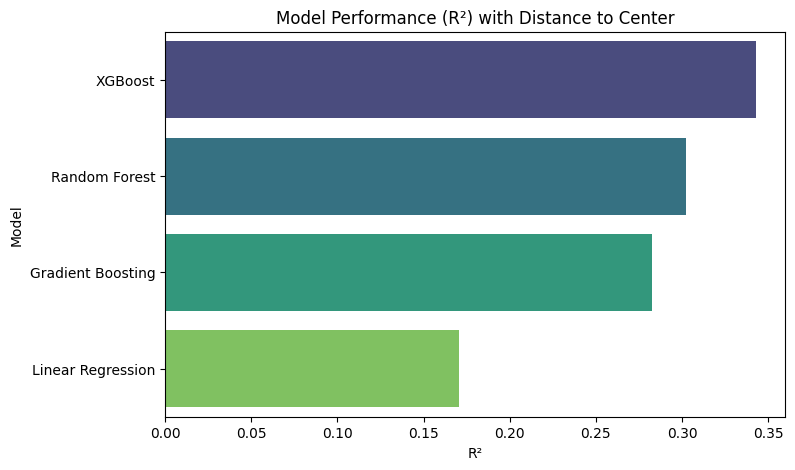

/var/folders/7w/mr3l1rjn21bd3r_kvq3bgr1h0000gn/T/ipykernel_54473/2153662217.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="RMSE", y="Model", palette="magma")


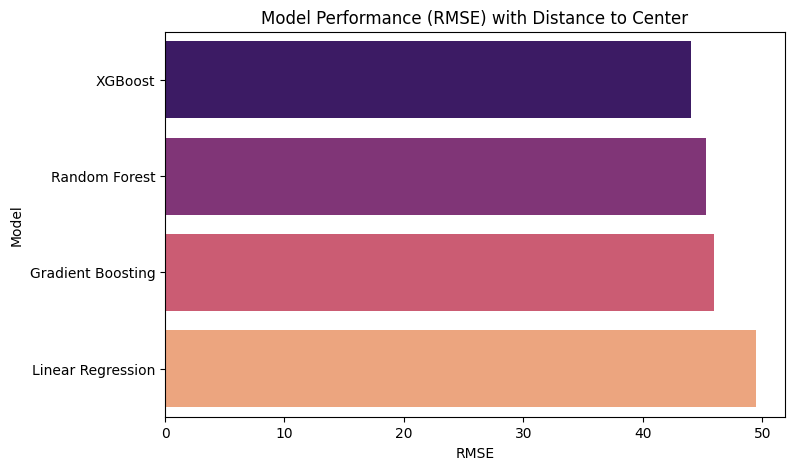

In [36]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="R²", y="Model", palette="viridis")
plt.title("Model Performance (R²) with Distance to Center")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="RMSE", y="Model", palette="magma")
plt.title("Model Performance (RMSE) with Distance to Center")
plt.show()